# Blockchain Address Clustering

This notebook implements a comprehensive approach to cluster blockchain addresses based on their transaction behavior. By analyzing transaction patterns, we aim to identify different types of entities in the blockchain ecosystem, such as exchanges, whale wallets, dormant accounts, and more.

We'll follow these steps:
1. Load and explore transaction data
2. Engineer meaningful features on address-level (static, temporal, and network-based)
3. Apply multiple clustering techniques
4. Evaluate and interpret the clusters

Our goal is to identify natural behavioral patterns among addresses and understand the various types of participants in the blockchain network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings

# Import our custom modules
from feature_extraction import extract_features
import address_clustering_tools as tools

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

## 1. Data Loading and Initial Exploration

We'll first load our blockchain transaction data and explore its basic characteristics. Each transaction contains a sender, recipient, amount, token type, block height (timestamp equivalent), and transaction hash.

In [2]:
path_to_json = "assignment/raw_data/transfers.jsonl"
sample = True  # Set to False to use full dataset

In [3]:
# Load transaction data
if sample: df = pd.read_json(path_to_json, lines=True, nrows=50000)  # Sample for faster processing
else: df = pd.read_json(path_to_json, lines=True)
# Ensure numeric types
df['amount'] = pd.to_numeric(df['amount'])
df['height'] = pd.to_numeric(df['height'])

In [4]:
# Display data overview
print(f"Transaction data shape: {df.shape}")
print("\nColumns:")
print(df.columns)
print("\nSample data:")
display(df.head())

# Basic statistics
print("\nBasic Dataset Statistics:")
print(f"Total transactions: {len(df):,}")
print(f"Unique senders: {df['sender'].nunique():,}")
print(f"Unique recipients: {df['recipient'].nunique():,}")
unique_addresses = len(pd.unique(df[['sender', 'recipient']].values.ravel('K')))
print(f"Unique addresses (combined): {unique_addresses:,}")
print(f"Block height range: {df['height'].min():,} to {df['height'].max():,}")

# Token diversity
print("\nToken diversity:")
token_counts = df['token'].value_counts()
display(token_counts.head(10))

Transaction data shape: (50000, 6)

Columns:
Index(['sender', 'recipient', 'amount', 'token', 'height', 'tx_hash'], dtype='object')

Sample data:


,sender,recipient,amount,token,height,tx_hash
0,9KHcuo6UBZfVGufF7WLZfjib55VeyJhnUeaujqrj3BE,9ox5eKEYpDvwKBgVquabuuYhkSDLWVQeP2HgU6tr5DfK,558675133,So11111111111111111111111111111111111111111,295666043,azM64zV35sxm2VUu2tFjuQqXvicDEPELam1uhXRe5CrDGo...
1,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,Gskzc4eJGF9FADgDRRQKw9pfjAoi2yojpLX26XE9YSTv,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
2,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,AC7w697BSC9hpJNQjC8S2HEcuAe1zyDEJe39vJLQWuHs,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
3,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,8CJukZAahrBh3qdN6dCcoLPtQXPPjDMPku925PXPhjxf,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
4,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,GVn46RgKhb4gvfYtuorwwVuDzz4rW3hBBjZAg3LzmqHp,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...



Basic Dataset Statistics:
Total transactions: 50,000
Unique senders: 15,308
Unique recipients: 13,722
Unique addresses (combined): 22,048
Block height range: 295,666,043 to 295,666,106

Token diversity:


token
So11111111111111111111111111111111111111111     28779
So11111111111111111111111111111111111111112      8016
EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v     1079
9K9BEXqaRasg63YhjXmHnHF9iXNrB6QwaU1iV87pump       444
9ZBYsQCNaR6Ck3KnwWwfWB4dLFKMakCuJaUGAHE8pump      440
7GF4v9SAd2Xm5sNJaDVKhfDDqFG5KuLgS6avhzfxPDUE      410
A3CoZkMecZaukxAZhsEvf4hinzcHRiu2zuUKvhvXv8Pp      297
4D3czYxrvfbxtkvb7cW8PMEXXcZyMYTCLsioeDXvuQcS      285
sp6DKKYq1MDXJi45QfbJyqvKwVxrNghTtZ9vH49pump       278
Es9vMFrzaCERmJfrF4H2FYD4KCoNkY11McCe8BenwNYB      239
Name: count, dtype: int64

## 2. Feature Engineering

We'll use our own custom `extract_features` function from the feature_extraction.py module. This function creates a rich set of features for each address. The feature extraction process transforms raw transaction data into meaningful behavioral metrics across multiple dimensions:

- **Transaction Metrics**: We extract basic counts (`tx_count_in`, `tx_count_out`, `tx_count_total`), volumes (`volume_in`, `volume_out`, `volume_total`, `volume_net`), and statistical measures of transaction values (`value_max`, `value_min`, `value_avg`, `value_std`, percentiles).

- **Temporal Patterns**: We analyze activity timing through features like `time_first_height`, `time_last_height`, `time_duration_blocks`, and block height ranges to understand when and how frequently addresses transact.

- **Counterparty Diversity**: We quantify relationship patterns with `counter_unique_senders`, `counter_unique_recipients` to measure how many different addresses an entity interacts with.

- **Token Usage**: We capture token diversity through `token_unique_in` and `token_unique_out` to identify addresses that interact with many different tokens versus those focusing on specific assets.

- **Network Position**: We compute graph-based centrality metrics (`network_degree`, `network_in_degree`, `network_out_degree`) that position addresses within the overall transaction network structure.

These features collectively create a behavioral fingerprint for each address, allowing our clustering algorithms to identify natural groupings that correspond to different types of blockchain participants like e.g. exchanges, individual users, smart contracts, and specialized services.

Note: While clustering could be performed at the transaction level, this analysis focuses on clustering addresses (as requested on the assigment) based on their aggregated transaction behaviors to identify distinct participant types.

Note: Feature engineering plays a critical role in achieving high-quality clustering results and effective anomaly detection (based on my experience!), and most of the effort has been concentrated on this step. The current feature set provides a foundation, though additional features could further enhance the analysis (see STEP 6: ADDITIONAL FEATURES in feature_extraction.py for potential extensions).

In [5]:
# Extract features using our dedicated function
print("Extracting features for all addresses...")
feature_df = extract_features(df)

print(f"Features extracted for {len(feature_df)} addresses with {feature_df.shape[1]} features")
display(feature_df.head())

Extracting features for all addresses...
Starting feature extraction process...
Computing sender metrics...
Computing recipient metrics...
Merging sender and recipient metrics...
Computing derived metrics...
Building transaction network graph...
Computing network centrality metrics...
Finalizing feature extraction...
Extracted features for 22048 addresses
Features extracted for 22048 addresses with 45 features


,tx_count_out,volume_out,value_max_out,value_min_out,value_avg_out,value_median_out,value_p25_out,value_p75_out,value_p90_out,value_std_out,...,volume_total,volume_net,value_min,value_max,time_first_height,time_last_height,time_duration_blocks,network_degree,network_in_degree,network_out_degree
address,,,,,,,,,,,,,,,,,,,,,
1226tAeNtn7ZGCamhMNCsLfCtPfrgyJ72DzZ44e3Vrzg,1.0,6.222101e+10,6.222101e+10,6.222101e+10,6.222101e+10,6.222101e+10,6.222101e+10,6.222101e+10,6.222101e+10,0.000000e+00,...,6.222101e+10,-6.222101e+10,0.0,6.222101e+10,0.0,295666049.0,295666049.0,0.000045,0.000000,0.000045
123JvycEQwHFtXgXtFzh8ExDER7L65bzAqRVRaJpSFtU,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+02,2.000000e+02,0.0,1.000000e+02,0.0,295666048.0,295666048.0,0.000091,0.000091,0.000000
125GzPkbpVSLhrp8fVa6N5qTAda1BKBSpXwzPAXoyQBh,4.0,9.103560e+06,7.039280e+06,1.250000e+03,2.275890e+06,1.031515e+06,1.812500e+04,3.289280e+06,5.539280e+06,3.316222e+06,...,2.376257e+10,2.374436e+10,100.0,2.375347e+10,295666091.0,295666096.0,5.0,0.000318,0.000136,0.000181
12C9Auc18zskAzjrVEarYEBaDHBoDXe2kwF7fSmKqUUA,1.0,9.900000e+05,9.900000e+05,9.900000e+05,9.900000e+05,9.900000e+05,9.900000e+05,9.900000e+05,9.900000e+05,0.000000e+00,...,1.990000e+06,1.000000e+04,990000.0,1.000000e+06,295666093.0,295666093.0,0.0,0.000091,0.000045,0.000045
12CMQHksyCZyj2Mu8xEDMo78RebjSC7XwPa5hN4cV4LW,7.0,2.035000e+07,1.000000e+07,1.000000e+04,2.907143e+06,1.000000e+05,7.000000e+04,5.050000e+06,1.000000e+07,4.845437e+06,...,3.662864e+11,3.662457e+11,10000.0,1.831330e+11,295666060.0,295666060.0,0.0,0.000227,0.000045,0.000181


### 2.1 Preprocessing Features

Before clustering, we need to preprocess our features to:
1. Handle missing values
2. Select relevant features
3. Scale the features

In [6]:
# Check for NaN and inf values
print("Checking for NaN and infinite values...")
nan_counts = feature_df.isna().sum()
inf_counts = feature_df.isin([np.inf, -np.inf]).sum()

# Display columns with issues
print("\nColumns with NaN values:")
display(nan_counts[nan_counts > 0])
print("\nColumns with infinite values:")
display(inf_counts[inf_counts > 0])

# Fill NaN values with 0 and replace inf with large values
feature_df.fillna(0, inplace=True)
feature_df.replace([np.inf, -np.inf], 1e6, inplace=True)

Checking for NaN and infinite values...

Columns with NaN values:


Series([], dtype: int64)


Columns with infinite values:


Series([], dtype: int64)

In [7]:
# Select features for clustering [we select all here, but we could select only the most relevant ones]
clustering_features = [
    'tx_count_in', 'tx_count_out', 'tx_count_total', # Transaction counts
    'volume_in', 'volume_out', 'volume_total', 'volume_net', # Volume metrics
    'value_avg_in', 'value_avg_out', 'value_max', 'value_min', # Transaction values
    'value_std_in', 'value_std_out',  # Transaction values
    'time_duration_blocks', 'time_height_range_in', 'time_height_range_out', # Time features
    'counter_unique_senders', 'counter_unique_recipients', # Diversity metrics
    'token_unique_in', 'token_unique_out', # Diversity metrics
    'network_degree', 'network_in_degree', 'network_out_degree'  # Network metrics
]

# Ensure all selected features exist
clustering_features = [f for f in clustering_features if f in feature_df.columns]
print(f"Selected {len(clustering_features)} features for clustering")

# Extract feature matrix
X = feature_df[clustering_features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Selected 23 features for clustering


### 2.2 Feature Dimensionality Analysis

After extracting our comprehensive feature set, we'll examine the intrinsic dimensionality of our data using a PCA scree plot. This visualization helps us understand how information is distributed across our feature space by showing the explained variance of each principal component. A steep curve with rapidly diminishing returns suggests our features capture a few dominant patterns, while a more gradual decline indicates complex, multidimensional behavior. This analysis serves several purposes: (1) it reveals potential redundancy among our extracted features, (2) it helps determine how many dimensions we need to preserve for effective clustering, and (3) it provides insight into the complexity of address behaviors in our dataset. By understanding the variance structure before clustering, we can make more informed decisions about dimensionality reduction techniques, clustering algorithms, and parameter selection in subsequent steps. The cumulative variance thresholds (shown by horizontal lines) indicate how many components we need to retain to preserve specific amounts of information.

Components needed for variance thresholds:
- 70% variance: 5 components
- 80% variance: 7 components
- 90% variance: 9 components
- 95% variance: 11 components
- 99% variance: 13 components


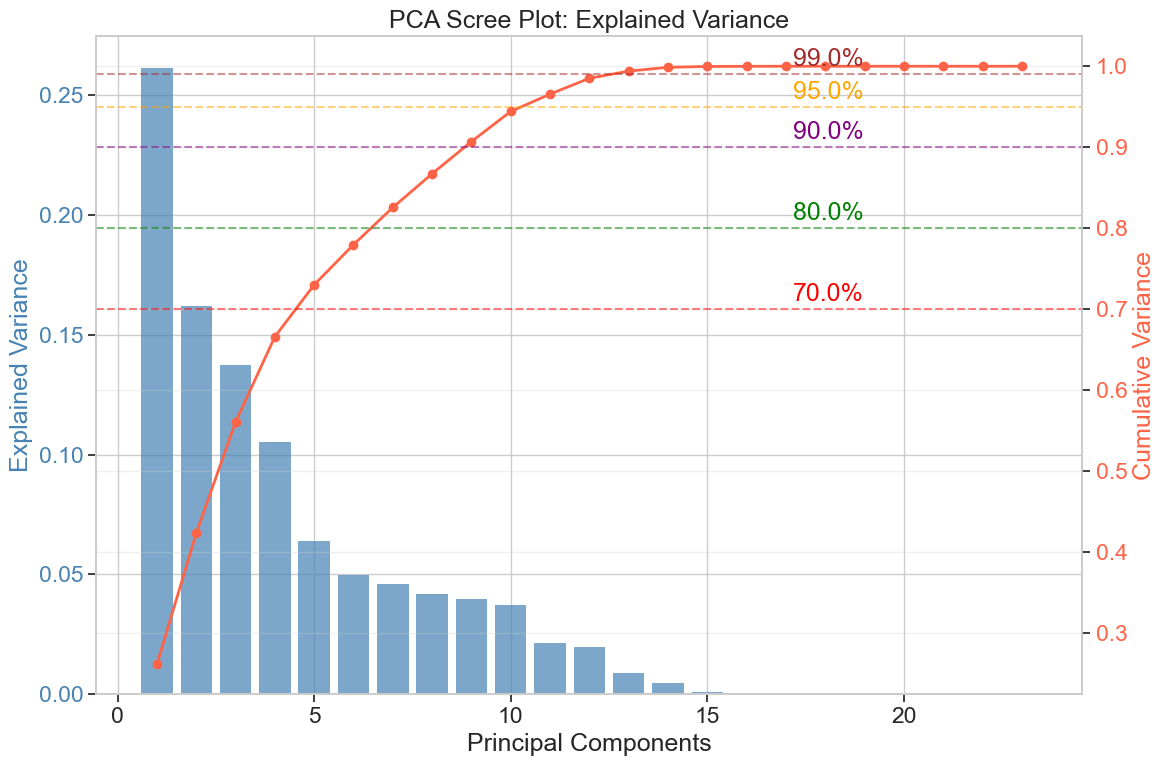

In [8]:
pca_results = tools.create_pca_scree_plot(X_scaled)

Note: We could apply PCA to reduce the dimensionality of the data, and used the reduced number of features for clustering.
This is useful sometimes, as prevents the curse of dimensionality and helps to find the optimal number of clusters.

## 3. Clustering

We'll use the tools from our tools.py module to help with clustering:

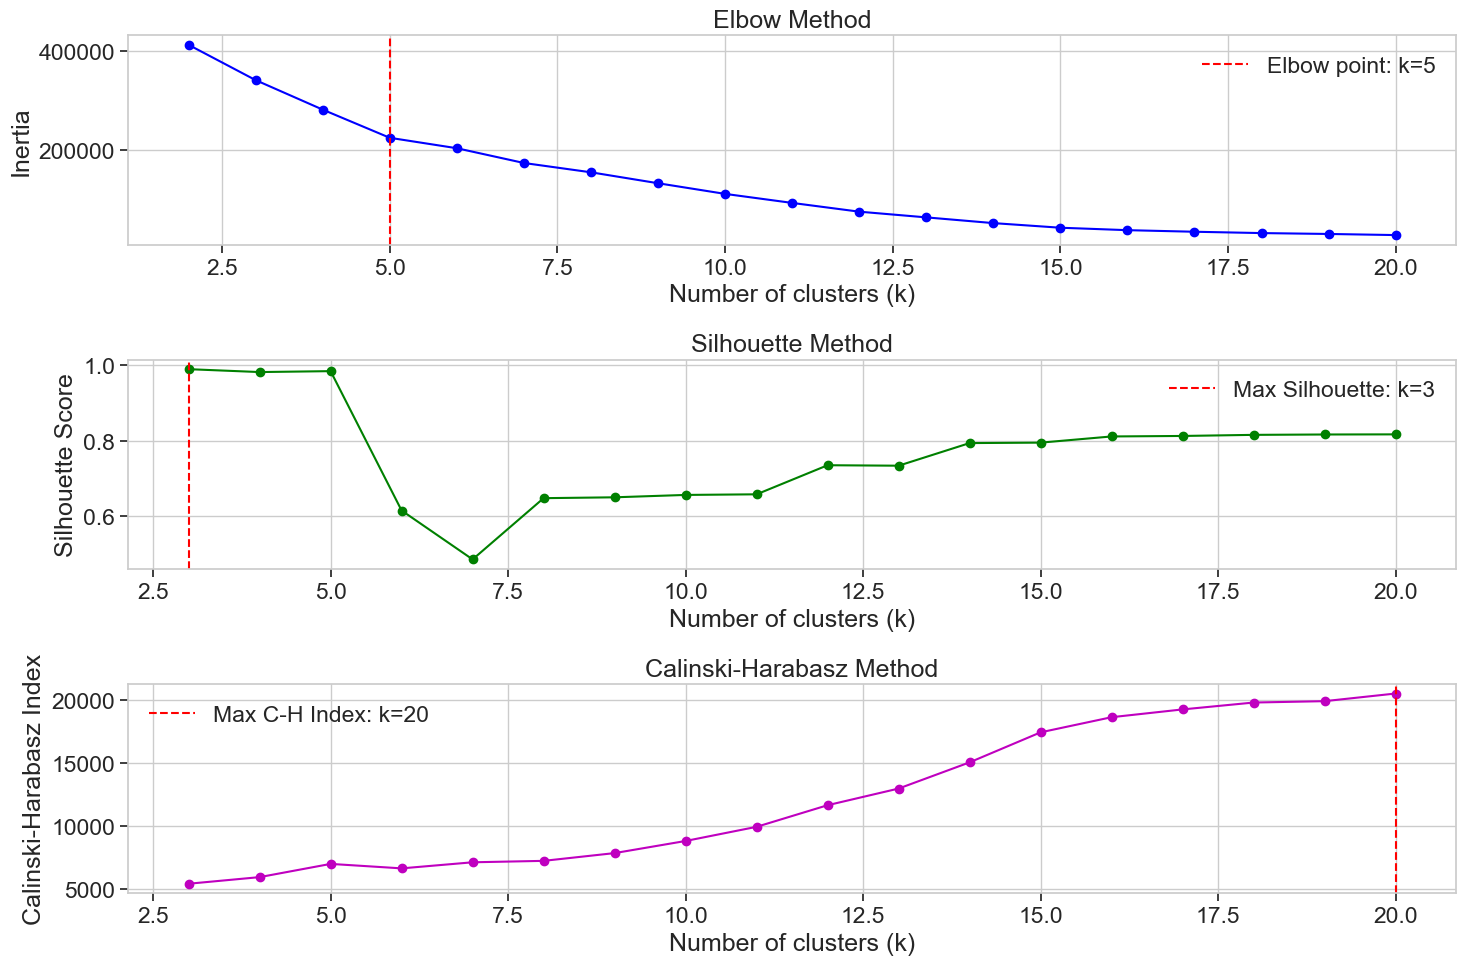


Optimal number of clusters: 5


In [9]:
# For finding optimal K
optimal_k, fig = tools.determine_optimal_k(X_scaled, k_range=(2, 20), methods=['elbow', 'silhouette', 'calinski_harabasz'])
plt.show()
print(f"\nOptimal number of clusters: {optimal_k}")

Looking at the plots above, there is no clear indication of an optimal number of clusters. The different metrics (elbow method, silhouette method, and Calinski-Harabasz method) don't show any clear inflection points or optimal values. [Selecting the optimal number of clusters in machine learning clustering techniques remains a challenging aspect of unsupervised learning. No single method is universally superior, and each has its strengths and limitations depending on the dataset characteristics and clustering objectives. Best practices suggest using multiple methods in conjunction to validate the choice of K, with final decisions often requiring a balance between statistical evidence and domain expertise.]

One hypothesis for this lack of clear clustering structure is the sensitivy of K-means to outliers. These outliers could be distorting the cluster centers and making it difficult to find natural groupings in the data. Pre-processing the data to remove outliers could help improve the clustering results.

Note: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is specifically designed to handle outliers effectively - and automatically find the optimal number of clusters. However, we are facing memory issues when running this algorithm on the full dataset.


In [10]:
# overwritting the optimal number of clusters
optimal_k = 15

Many choices of clustering algorithms could be used here, but we will focus on K-means, Hierarchical clustering and DBSCAN.

| Criteria | K-Means | DBSCAN | Hierarchical |
|---------------------|-------------|------------|------------------|
| Cluster Shapes | Spherical | Arbitrary | Arbitrary |
| Noise Handling | Poor | Excellent | Moderate |
| Scalability | High | Medium | Low |

In [11]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to feature DataFrame
feature_df['kmeans_cluster'] = kmeans_labels

# Display cluster sizes
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print("K-means cluster sizes:")
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} addresses ({size/len(feature_df)*100:.1f}%)")

K-means cluster sizes:
Cluster 0: 7368 addresses (33.4%)
Cluster 1: 1 addresses (0.0%)
Cluster 2: 1 addresses (0.0%)
Cluster 3: 2 addresses (0.0%)
Cluster 4: 6083 addresses (27.6%)
Cluster 5: 1 addresses (0.0%)
Cluster 6: 3 addresses (0.0%)
Cluster 7: 1 addresses (0.0%)
Cluster 8: 22 addresses (0.1%)
Cluster 9: 990 addresses (4.5%)
Cluster 10: 6423 addresses (29.1%)
Cluster 11: 5 addresses (0.0%)
Cluster 12: 1 addresses (0.0%)
Cluster 13: 1143 addresses (5.2%)
Cluster 14: 4 addresses (0.0%)


Clusters with 1 address only could be a sign of an anomalous address.

In [12]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add hierarchical labels to feature DataFrame
feature_df['hierarchical_cluster'] = hierarchical_labels

# Display hierarchical clustering results
h_cluster_sizes = pd.Series(hierarchical_labels).value_counts().sort_index()
print("Hierarchical clustering sizes:")
for cluster, size in h_cluster_sizes.items():
    print(f"Cluster {cluster}: {size} addresses ({size/len(feature_df)*100:.1f}%)")

Hierarchical clustering sizes:
Cluster 0: 1612 addresses (7.3%)
Cluster 1: 7233 addresses (32.8%)
Cluster 2: 32 addresses (0.1%)
Cluster 3: 817 addresses (3.7%)
Cluster 4: 5 addresses (0.0%)
Cluster 5: 6447 addresses (29.2%)
Cluster 6: 4 addresses (0.0%)
Cluster 7: 1 addresses (0.0%)
Cluster 8: 2 addresses (0.0%)
Cluster 9: 1 addresses (0.0%)
Cluster 10: 2 addresses (0.0%)
Cluster 11: 1 addresses (0.0%)
Cluster 12: 1 addresses (0.0%)
Cluster 13: 1 addresses (0.0%)
Cluster 14: 5889 addresses (26.7%)


**Note on DBSCAN Parameters:** We selected eps=0.5 and min_samples=5 as reasonable defaults for this demonstration of DBSCAN clustering on blockchain data. Due to computational constraints with our large dataset, we've implemented DBSCAN without full parameter optimization (which would require multiple runs and k-distance analysis). These parameters offer a balance between cluster granularity and noise identification.

In [13]:
eps_value = 0.4
min_samples_value = 5 

# Apply DBSCAN clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to feature DataFrame (noise points will be -1)
feature_df['dbscan_cluster'] = dbscan_labels

# Display cluster sizes including noise points
unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Results (EPS={eps_value}, Min Samples={min_samples_value}):")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise} ({n_noise/len(feature_df)*100:.1f}% of total)")

print("\nCluster sizes:")
cluster_sizes = pd.Series(dbscan_labels).value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    cluster_type = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"{cluster_type}: {size} addresses ({size/len(feature_df)*100:.1f}%)")

DBSCAN Results (EPS=0.4, Min Samples=5):
Estimated number of clusters: 8
Estimated number of noise points: 468 (2.1% of total)

Cluster sizes:
Noise: 468 addresses (2.1%)
Cluster 0: 8230 addresses (37.3%)
Cluster 1: 6617 addresses (30.0%)
Cluster 2: 6698 addresses (30.4%)
Cluster 3: 10 addresses (0.0%)
Cluster 4: 9 addresses (0.0%)
Cluster 5: 6 addresses (0.0%)
Cluster 6: 5 addresses (0.0%)
Cluster 7: 5 addresses (0.0%)


## 4. Cluster Evaluation and Visualization

Let's evaluate our clustering results using metrics and visualizations from our tools module:

In [14]:
# Compute evaluation metrics
metrics_df = pd.DataFrame(index=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'])

# K-means metrics
metrics_df['K-means'] = [
    silhouette_score(X_scaled, kmeans_labels),
    davies_bouldin_score(X_scaled, kmeans_labels),
    calinski_harabasz_score(X_scaled, kmeans_labels)
]

# Hierarchical metrics
metrics_df['Hierarchical'] = [
    silhouette_score(X_scaled, hierarchical_labels),
    davies_bouldin_score(X_scaled, hierarchical_labels),
    calinski_harabasz_score(X_scaled, hierarchical_labels)
]

# DBSCAN metrics (excluding noise points)
dbscan_mask = dbscan_labels != -1  # Filter out noise points
if len(np.unique(dbscan_labels[dbscan_mask])) > 1:  # Need at least 2 clusters
    metrics_df['DBSCAN'] = [
        silhouette_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask]),
        davies_bouldin_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask]),
        calinski_harabasz_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
    ]
else:
    metrics_df['DBSCAN'] = [np.nan, np.nan, np.nan]
    print("Warning: DBSCAN found <2 clusters - metrics not calculated")

# Display metrics
display(metrics_df)

print("Interpretation:")
print("- Higher Silhouette Score is better (max 1.0)")
print("- Lower Davies-Bouldin Index is better")
print("- Higher Calinski-Harabasz Score is better")

,K-means,Hierarchical,DBSCAN
Silhouette Score,0.795480,0.787523,0.673469
Davies-Bouldin Index,0.449365,0.434123,0.401153
Calinski-Harabasz Score,17439.156478,15299.182167,4536.711207


Interpretation:
- Higher Silhouette Score is better (max 1.0)
- Lower Davies-Bouldin Index is better
- Higher Calinski-Harabasz Score is better


From this comparison, K-means performs better than hierarchical clustering (and that DBSCAN), and therefore used in the rest of the analysis.

In [15]:
fig, projections = tools.visualize_clusters_2d_interactive(
    X_scaled, 
    kmeans_labels,
    max_samples=10000,  # Increase sample size if needed
    calculate_silhouette=False,  # Skip silhouette score for speed
    methods=['pca', 'tsne', 'umap']  # Skip UMAP if not needed
)
fig

Dataset has 22048 samples. Subsampling to 10000 for visualization...
Metrics calculated in 0.03 seconds
PCA completed in 1.91 seconds
Running t-SNE with perplexity=30, n_jobs=-1...
t-SNE completed in 24.90 seconds
Running UMAP with n_neighbors=15, min_dist=0.1...
UMAP completed in 29.32 seconds
Total visualization time: 56.31 seconds


## 5. Cluster Interpretation

Now let's interpret what each cluster represents by analyzing their feature profiles:

,cluster_size,tx_count_in,tx_count_out,tx_count_total,volume_in,volume_out,volume_total,volume_net,value_avg_in,value_avg_out,...,time_duration_blocks,time_height_range_in,time_height_range_out,counter_unique_senders,counter_unique_recipients,token_unique_in,token_unique_out,network_degree,network_in_degree,network_out_degree
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,7368,0.000000,1.442590,1.442590,0.000000e+00,5.212360e+13,5.212360e+13,-5.212360e+13,0.000000e+00,5.156891e+13,...,2.956661e+08,0.000000,0.749729,0.000000,1.344191,0.000000,1.000000,0.000061,0.000000,0.000061
1,1,5199.000000,0.000000,5199.000000,1.154151e+17,0.000000e+00,1.154151e+17,1.154151e+17,2.219948e+13,0.000000e+00,...,2.956661e+08,63.000000,0.000000,3379.000000,0.000000,444.000000,0.000000,0.153263,0.153263,0.000000
2,1,0.000000,1.000000,1.000000,0.000000e+00,4.040971e+17,4.040971e+17,-4.040971e+17,0.000000e+00,4.040971e+17,...,2.956661e+08,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000045,0.000000,0.000045
3,2,0.000000,2087.000000,2087.000000,0.000000e+00,2.087000e+05,2.087000e+05,-2.087000e+05,0.000000e+00,1.000000e+02,...,2.956661e+08,0.000000,61.500000,0.000000,1621.000000,0.000000,1.000000,0.073525,0.000000,0.073525
4,6083,1.560907,0.000000,1.560907,2.783156e+12,0.000000e+00,2.783156e+12,2.783156e+12,1.759065e+12,0.000000e+00,...,2.956661e+08,1.150748,0.000000,1.388295,0.000000,1.247740,0.000000,0.000063,0.000063,0.000000
5,1,490.000000,0.000000,490.000000,4.109661e+17,0.000000e+00,4.109661e+17,4.109661e+17,8.387064e+14,0.000000e+00,...,2.956661e+08,61.000000,0.000000,217.000000,0.000000,77.000000,0.000000,0.009843,0.009843,0.000000
6,3,0.000000,2.666667,2.666667,0.000000e+00,2.149456e+16,2.149456e+16,-2.149456e+16,0.000000e+00,7.431359e+15,...,2.956661e+08,0.000000,24.333333,0.000000,2.666667,0.000000,1.000000,0.000121,0.000000,0.000121
7,1,1.000000,2.000000,3.000000,2.230100e+15,1.373073e+15,3.603174e+15,8.570270e+14,2.230100e+15,6.865367e+14,...,3.600000e+01,0.000000,14.000000,1.000000,2.000000,1.000000,1.000000,0.000136,0.000045,0.000091
8,22,532.136364,72.909091,605.045455,2.959747e+12,7.721228e+07,2.959824e+12,2.959670e+12,1.045845e+10,2.207177e+05,...,2.015905e+08,61.500000,19.272727,287.681818,16.545455,14.272727,0.318182,0.013799,0.013049,0.000750


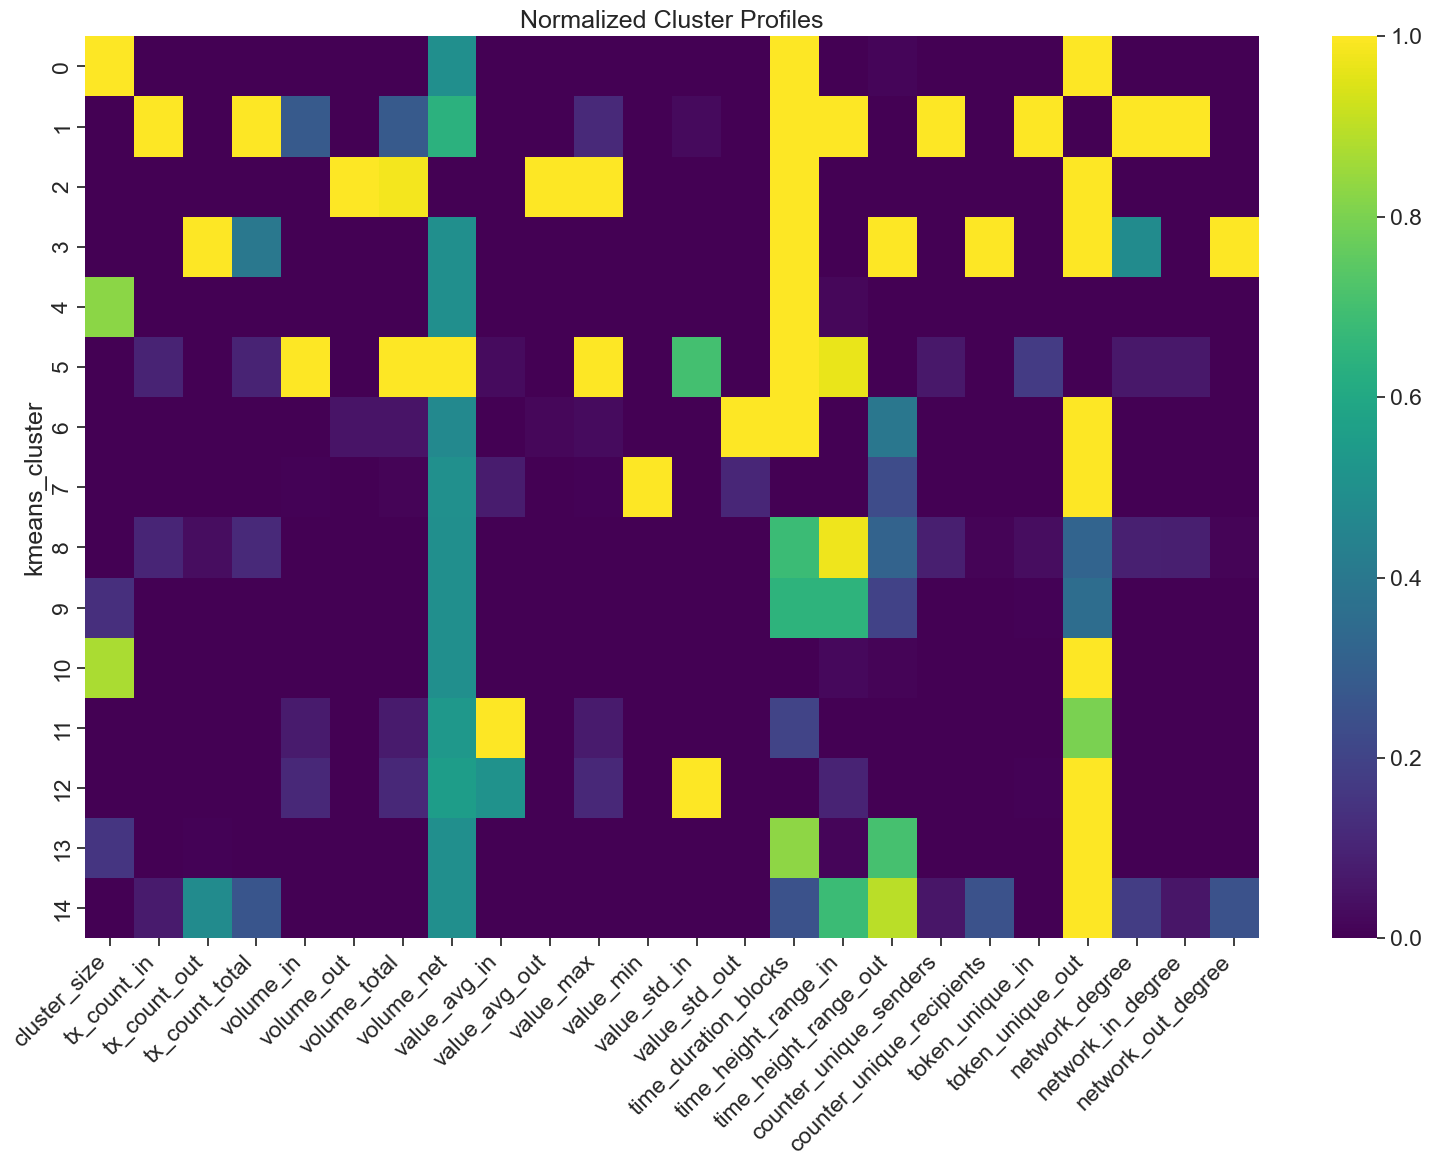

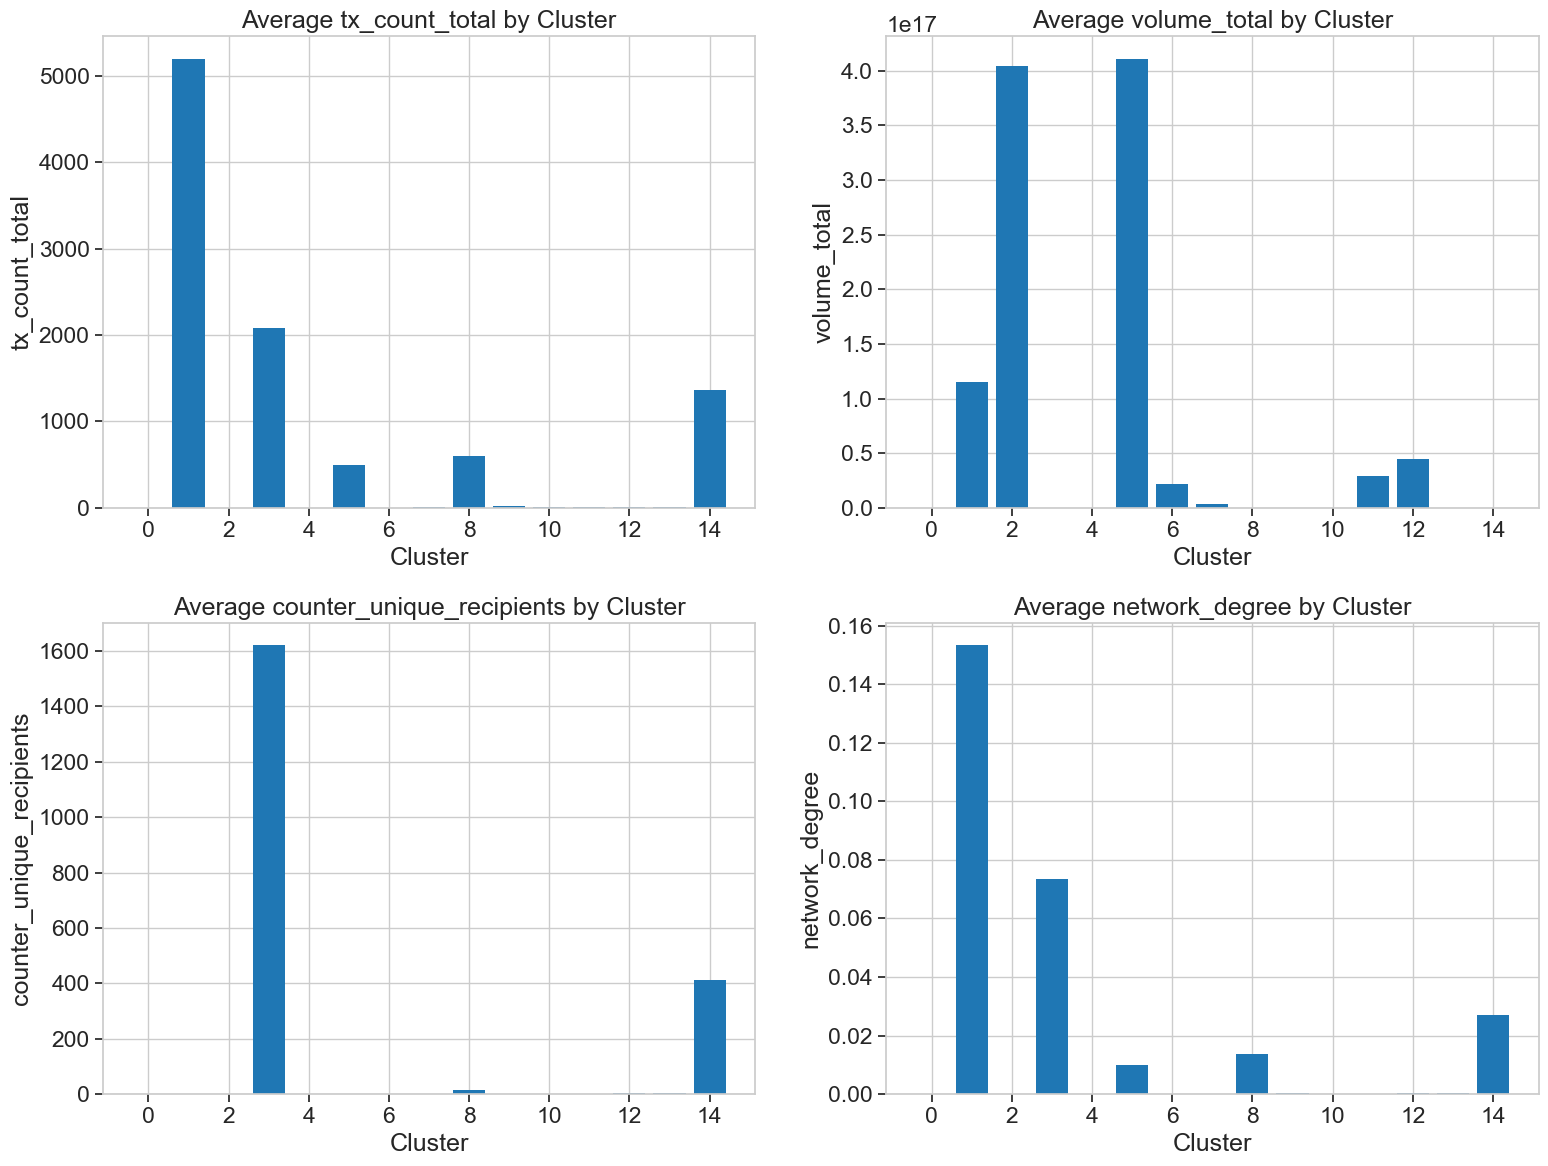

In [16]:
# Create cluster profiles
cluster_sizes = feature_df['kmeans_cluster'].value_counts()
cluster_profiles = feature_df.groupby('kmeans_cluster')[clustering_features].mean()

# Add cluster sizes as first column
cluster_profiles.insert(0, 'cluster_size', cluster_sizes)

# Display profiles
display(cluster_profiles)

# Normalize profiles for better comparison
normalized_profiles = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Create heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(normalized_profiles, cmap='viridis', annot=False)
plt.title('Normalized Cluster Profiles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize key metrics for each cluster
key_metrics = ['tx_count_total', 'volume_total', 'counter_unique_recipients', 'network_degree']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(key_metrics):
    axes[i].bar(cluster_profiles.index, cluster_profiles[metric])
    axes[i].set_title(f'Average {metric} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

# Cluster Interpretation Process: Domain Expertise & Iterative Refinement

## The Role of Domain Expertise
Interpreting blockchain address clusters requires significant domain knowledge:
- Blockchain experts can recognize patterns typical of exchanges, whales, or services
- External data sources (e.g., known address labels) can validate interpretations
- Industry context helps understand emerging behavioral patterns unique to each ecosystem

## Iterative Clustering Approach
Finding meaningful clusters is an iterative process:
1. Start with a theoretical k based on expected user types
2. Analyze each cluster's statistical profile (transaction counts, volumes, network metrics)
3. Assess if clusters align with recognizable user behaviors
4. Adjust k up or down based on separation quality and interpretability
5. Repeat until clusters exhibit distinct, meaningful profiles
6. Validate using silhouette scores and other clustering metrics

## Recognizing Typical vs. Novel Patterns
When examining cluster statistics:
- Some clusters will match expected profiles (exchanges, whales, traders, etc.)
- Unexpected clusters may represent:
  * Previously unknown user types specific to this blockchain
  * Emerging behaviors (new DeFi patterns, novel financial instruments)
  * Potential anomalies requiring further investigation
  * Technical artifacts or specialized protocols

## Beyond Identification: Continuous Learning
The interpretation process should be:
- Documented with clear rationales for cluster labeling
- Updated as new blockchain behaviors emerge
- Used to build a knowledge base of behavioral patterns
- Applied to detect shifts in ecos
çystem dynamics over time
- Leveraged to identify addresses that deviate from their cluster's typical behavior

This interpretive process transforms abstract mathematical clusters into actionable intelligence about blockchain participants, bridging data science techniques with domain-specific expertise.

## Potential Applications
Successfully interpreted clusters could enable:
- Identification of addresses that deviate from their cluster's typical behavior
- Recognition of patterns that might indicate specialized activities
- Understanding the composition and health of the blockchain ecosystem
- Monitoring changes in user behavior over time
- Detecting unusual relationships between different user types